https://scholarworks.calstate.edu/downloads/02870z096
https://www.kaggle.com/code/rahuldshetty/hair-segmentation-using-u-net/notebook


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.compat.v1.metrics import mean_iou

from skimage.transform import resize

In [ ]:
mask = "/content/drive/MyDrive/Collab DataSets/Training_Mask"
org = "/content/drive/MyDrive/Collab DataSets/Training_Org"



In [ ]:
x = os.listdir(org)
y = os.listdir(mask)

In [ ]:
x_paths = x
y_paths = []

for i in y:
  if not i.__contains__('(1)'):
    y_paths.append(i)

print(len(x_paths),len(y_paths))

1050 1050


In [20]:
from posix import mkdir
def loader(xpath,ypath, filenames):
  images = []
  masks = []
  count = 0
  for filename in filenames:
    mask_filename = filename.replace("-org.jpg", "-gt.pbm")
    img = cv2.imread(os.path.join(xpath,filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mk = cv2.imread(os.path.join(ypath,mask_filename))
    mk = cv2.cvtColor(mk, cv2.COLOR_BGR2GRAY)
    if img is not None and mk is not None:
      images.append(img)
      masks.append(mk)
      count += 1
      print(count)
  return images, masks

In [ ]:
images, masks = loader(org, mask, x_paths)

In [22]:
size = len(images)

np_images = np.zeros((size,224,224,1))
np_masks = np.zeros((size,224,224,1))

for i in range(size):
    img = images[i]
    msk = masks[i]
    np_images[i] = resize(img,(224,224)).reshape((224,224,1))
    np_masks[i] = resize(msk,(224,224)).reshape((224,224,1))

In [27]:
np_images[0].shape

(224, 224, 1)

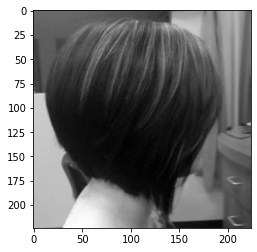

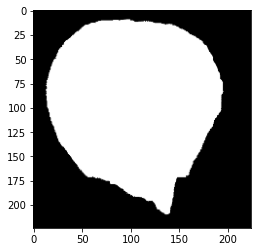

In [29]:
images, masks = None, None
plt.imshow(np.squeeze(np_images[10]), cmap="gray")
plt.show()
plt.imshow(np.squeeze(np_masks[10]), cmap="gray")

In [ ]:
# for i in range(len(images)):
#   images[i] = cv2.resize(images[i], (224,224), interpolation = cv2.INTER_AREA)
#   masks[i] = cv2.resize(masks[i], (224,224), interpolation = cv2.INTER_AREA)

In [32]:
# inputs = Input((224,224,3))
inputs = Input((224,224,1))

c1 = Conv2D(32, (3,3), activation = "relu", padding = "same")(inputs)
c1 = Conv2D(32, (3,3), activation = "relu", padding = "same")(c1)
p1 = MaxPooling2D((2,2))(c1)

c2 = Conv2D(64, (3,3), activation = "relu", padding = "same")(p1)
c2 = Conv2D(64, (3,3), activation = "relu", padding = "same")(c2)
p2 = MaxPooling2D((2,2))(c2)

c3 = Conv2D(128, (3,3), activation = "relu", padding = "same")(p2)
c3 = Conv2D(128, (3,3), activation = "relu", padding = "same")(c3)
p3 = MaxPooling2D((2,2))(c3)

c4 = Conv2D(256, (3,3), activation = "relu", padding = "same")(p3)
c4 = Conv2D(256, (3,3), activation = "relu", padding = "same")(c4)
p4 = MaxPooling2D((2,2))(c4)

c5 = Conv2D(512, (3,3), activation = "relu", padding = "same")(p4)
c5 = Conv2D(512, (3,3), activation = "relu", padding = "same")(c5)

u6 = Conv2DTranspose( 224, (2,2), strides = (2,2), padding = "same")(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(256, (3,3), activation = "relu", padding = "same")(u6)
c6 = Conv2D(256, (3,3), activation = "relu", padding = "same")(c6)

u7 = Conv2DTranspose( 224 >> 1, (2,2), strides = (2,2), padding = "same")(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(128, (3,3), activation = "relu", padding = "same")(u7)
c7 = Conv2D(128, (3,3), activation = "relu", padding = "same")(c7)

u8 = Conv2DTranspose( 224 >> 2, (2,2), strides = (2,2), padding = "same")(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(64, (3,3), activation = "relu", padding = "same")(u8)
c8 = Conv2D(64, (3,3), activation = "relu", padding = "same")(c8)

u9 = Conv2DTranspose( 224 >> 3, (2,2), strides = (2,2), padding = "same")(c8)
u9 = concatenate([u9, c1], axis = 3)
c9 = Conv2D(32, (3,3), activation = "relu", padding = "same")(u9)
c9 = Conv2D(32, (3,3), activation = "relu", padding = "same")(c9)

outputs = Conv2D(1, (1,1), activation = "sigmoid")(c9)
model = Model(inputs = [inputs], outputs = [outputs])
model.compile(optimizer = Adam(lr=0.001), loss = "binary_crossentropy", metrics = ["acc"])
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 224, 224, 32  320         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_58 (Conv2D)             (None, 224, 224, 32  9248        ['conv2d_57[0][0]']              
                                )                                                           

In [33]:
epochs = 50
history = model.fit(np_images, np_masks, validation_split = 0.05, epochs = epochs,batch_size = 64)

Epoch 1/50
16/16 [==============================] - 17s 912ms/step - loss: 0.6087 - acc: 0.6097 - val_loss: 0.6079 - val_acc: 0.5895
Epoch 2/50
16/16 [==============================] - 14s 865ms/step - loss: 0.5488 - acc: 0.6419 - val_loss: 0.6075 - val_acc: 0.5496
Epoch 3/50
16/16 [==============================] - 14s 873ms/step - loss: 0.5622 - acc: 0.6270 - val_loss: 0.5737 - val_acc: 0.5525
Epoch 4/50
16/16 [==============================] - 14s 876ms/step - loss: 0.5190 - acc: 0.6410 - val_loss: 0.5691 - val_acc: 0.5592
Epoch 5/50
16/16 [==============================] - 14s 869ms/step - loss: 0.5073 - acc: 0.6316 - val_loss: 0.5602 - val_acc: 0.5731
Epoch 6/50
16/16 [==============================] - 14s 867ms/step - loss: 0.4993 - acc: 0.6282 - val_loss: 0.5572 - val_acc: 0.5883
Epoch 7/50
16/16 [==============================] - 14s 864ms/step - loss: 0.5847 - acc: 0.6235 - val_loss: 0.6115 - val_acc: 0.5727
Epoch 8/50
16/16 [==============================] - 14s 860ms/step - 

In [34]:
model.save('model.h5')

In [84]:
test_pic = cv2.imread("/content/drive/MyDrive/Collab DataSets/Face1.png")
test_pic_pred = cv2.imread("/content/drive/MyDrive/Collab DataSets/Face1.png", 0)
test_pic = cv2.resize(test_pic, [224,224], interpolation = cv2.INTER_AREA)
test_pic_pred = cv2.resize(test_pic_pred, [224,224], interpolation = cv2.INTER_AREA)

In [86]:
mask = model.predict(np.asarray([test_pic_pred])).reshape((224,224))


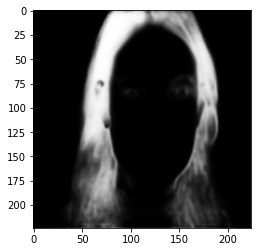

In [102]:
plt.imshow(mask, cmap="gray")